In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from copy import deepcopy
import sys
from functools import partial

In [54]:
def samples_shape_for_idx(data_idx):
    sys.argv[1] = data_idx
    if data_idx == 0:
        from data import samples1, samples2, func
    elif data_idx == 1:
        from big_data import samples1, samples2, func
    elif data_idx == 2:
        from biggest_data import samples1, samples2, func
    elif data_idx == 3:
        from biggest_data2 import samples1, samples2, func
    elif data_idx >= 4 and int(sys.argv[1]) < 100:
        from scattered import samples1, samples2, func
    elif data_idx == 100:
        from usamples1 import samples1, samples2, cells_size, cells_count, func
    elif data_idx == 101:
        from usamples2 import samples1, samples2, cells_size, cells_count, func
    elif data_idx == 102:
        from usamples3 import samples1, samples2, cells_size, cells_count, func
    elif data_idx == 103:
        from usamples4 import samples1, samples2, cells_size, cells_count, func
    return samples1, samples2

lines_pattern = '([^\s]+) : ([^\n]*)'

def handle_line(match):
    if len(match.group(2)) > 0:
        return match.group(1), float(match.group(2))
    else:
        return match.group(1), ""

def parse_file(filename, pattern):
    result = dict()
    
    data_idx = int(filename[6:filename.index('_')])
    result['data_idx'] = data_idx
    result['shapes'] = tuple(map(lambda s: s.shape, samples_shape_for_idx(data_idx)))
    
    result['max_distance'] = float(filename[filename.index('_')+1:filename.rindex('.')])
    
    best = (None,100000)
    with open("results/" + filename, "r") as file:
        data = file.read()
        
        by_bpc = {}
        by_bpa = {}
        pycsou = {}
        for script_name, time  in map(handle_line, re.finditer(lines_pattern, data)):
            match = re.search(pattern, script_name)
            if match:
                bpa, bpc = int(match.group(1)), int(match.group(2))

                if bpa not in by_bpa:
                    by_bpa[bpa] = []
                by_bpa[bpa].append((bpc, time))

                if bpc not in by_bpc:
                    by_bpc[bpc] = []
                by_bpc[bpc].append((bpa, time))
            elif script_name[:6] == 'pycsou':
                pycsou[script_name[script_name.index('_')+1:-3]] = time
                
            if isinstance(time, float) and time < best[1]:
                best = (script_name, float(time))
                
        result['by_bpa'] = by_bpa
        result['by_bpc'] = by_bpc
        result['pycsou'] = pycsou
        result['best'] = best
    
    return result

In [100]:
def ticks_and_values(dc):
    ticks = []
    values = []
    secondary_keys = []
    for key, ls in sorted(dc.items()):
        for secondary_key, value in ls:
            ticks.append(key)
            values.append(value)
            secondary_keys.append(secondary_key)
    return ticks, values, secondary_keys

def plot_as_scatter(dc, colorbar_label, xlabel, logy=False, logx=False, logc=False, big=False, label=None,
                    annotate=True, exclude=(), pycsou=['dask', 'sparse']):
    plt.title('samples1={}, samples2={}, Max distance={}'.format(*dc['shapes'], dc['max_distance']))
    
    # we make a copy to be sure
    dc = deepcopy(dc)
    
    primary_keys_sorted = sorted(list(dc['by_bpa'].keys()))
    for idx in exclude:
        print('excluding bpa={}'.format(primary_keys_sorted[idx]))
        dc['by_bpa'][primary_keys_sorted[idx]] = []
    
    ticks, values, secondary_keys = ticks_and_values(dc['by_bpa'])
    secondary_keys = np.array(list(secondary_keys))
    
    if not logc:
        sc = plt.scatter(ticks, values, c=secondary_keys, s=100, label=label)
    else:
        sc = plt.scatter(ticks, values, c=secondary_keys, s=100, label=label,
                         norm=colors.LogNorm(vmin=secondary_keys.min(), vmax=secondary_keys.max()))
    
    plt.grid()
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    
    if not logc:
        clb = plt.colorbar(sc, ticks=np.unique(secondary_keys))
    else:
        clb = plt.colorbar(sc, ticks=np.unique(secondary_keys), extend='max')
        
    if big:
        clb.ax.tick_params(labelsize=15)
        clb.ax.set_title(colorbar_label, fontsize=15)
    else:
        clb.ax.set_title(colorbar_label)
    
    max_tick = max(filter(lambda val: len(dc['by_bpa'][val]) > 0, ticks))
    min_tick = min(filter(lambda val: len(dc['by_bpa'][val]) > 0, ticks))
    # pycsou
    for p, color in zip(pycsou, ['r', 'g']):
        if not isinstance(dc['pycsou'][p], float):
            print('Skipping pycous-{} because data is not available'.format(p))
            
        t = dc['pycsou'][p]
        plt.hlines(t, min_tick, max_tick, color=color, label='Pycsou-{}'.format(p))
        
        if annotate:
            plt.annotate(np.round(t, 3), (2.5, t+0.05))
    
    # best
    best = dc['best'][1]
    plt.hlines(best, min_tick, max_tick, color='b', label='Best ({})'.format(dc['best'][0][:-3]))
    if annotate:
        plt.annotate(np.round(best, 3), (2.5, best+0.05))
    
    plt.legend()
    plt.ylabel('Seconds')
    plt.xlabel(xlabel)
    
    plt.xticks(np.unique(ticks), np.unique(ticks))

In [59]:
patterns = {
    0: 'pmb_(\d+)_(\d+).py', # inverse of paper with map_blocks
    1: 'pf_(\d+)_(\d+).py',  # inverse of paper with future
    2: 'pif_(\d+)_(\d+).py', # like paper
    3: 'pifr_(\d+)_(\d+).py' # like 2, with reference bin
}

xlabel = {
    0: 'Bins per axis',
    1: 'Bins per axis',
    2: 'Bins size (#cells)',
}
xlabel[3] = xlabel[2]

colorbar_label = {
    0: 'Bins per Dask chunk',
    1: 'Bins per Future',
    2: 'Points per future'
}
colorbar_label[3] = colorbar_label[2]

label = {
    0: 'map_blocks',
    1: 'Future (inverse of paper)',
    2: 'Future (like paper)',
    3: 'Future (like paper) with ref. bin'
}

## Results

In [68]:
pattern_idx = 2
file_parser = partial(parse_file, pattern=patterns[pattern_idx])

In [69]:
outputs = sorted(os.listdir('results/'))
results = {(dc['data_idx'], dc['max_distance']) : dc for dc in map(file_parser, outputs)}

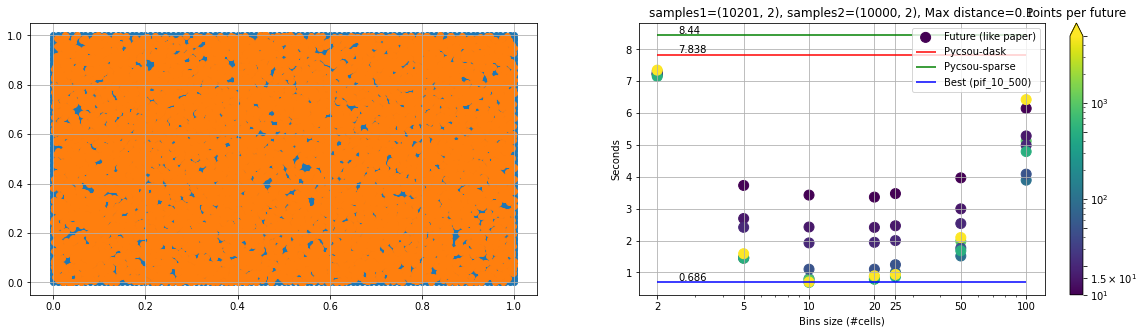

In [107]:
data_idx = 102
distance = 0.1

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
samples1, samples2 = samples_shape_for_idx(data_idx)
plt.scatter(samples1[:,0], samples1[:,1], label='samples1')
plt.scatter(samples2[:,0], samples2[:,1], label='samples2')
plt.grid()

plt.subplot(1,2,2)
plot_as_scatter(results[(data_idx, distance)], 
                xlabel=xlabel[pattern_idx], label=label[pattern_idx], colorbar_label=colorbar_label[pattern_idx], 
                logx=True, logc=True, 
                pycsou=['dask', 'sparse'])

plt.show()

## Results (bigger)

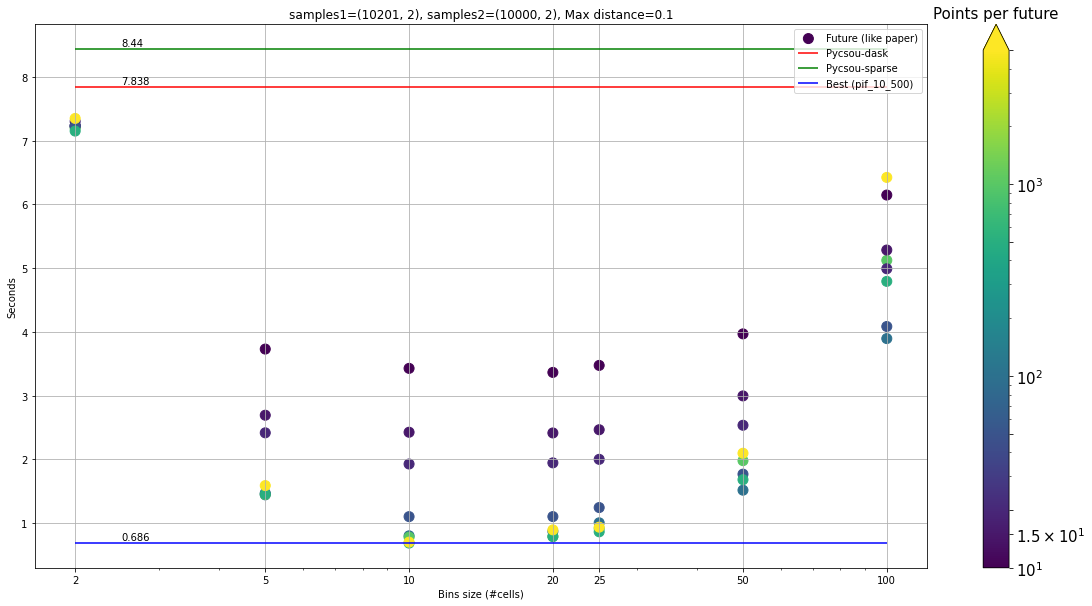

In [108]:
plt.figure(figsize=(20,10))
plot_as_scatter(results[(data_idx, distance)], 
                logc=True, logx=True, big=True,
                colorbar_label=colorbar_label[pattern_idx], label=label[pattern_idx], xlabel=xlabel[pattern_idx], 
                pycsou=['dask', 'sparse'])
plt.show()